# 2. Data Preprocessing - Gold Price Forecasting

**Objective:** Clean, transform, and prepare data for machine learning models.

**Author:** Félix Jouary  
**Dataset:** Kaggle Gold Price Dataset

## 2.1 Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2.2 Load Raw Data

In [26]:
# Load the daily dataset
df = pd.read_csv('../data/raw/Daily.csv', na_values=['#N/A', '#N/A N/A', 'N/A'])

# Fix numeric columns - remove commas and convert to float
for col in df.columns:
    if col != 'Date':
        df[col] = df[col].replace({',': ''}, regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert Date column
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

print(f"Original dataset shape: {df.shape}")
df.head()

Original dataset shape: (11626, 20)


,Date,USD,EUR,JPY,GBP,CAD,CHF,INR,CNY,TRY,SAR,IDR,AED,THB,VND,EGP,KRW,RUB,ZAR,AUD
0,1978-12-29,226.0,137.1,NaN,110.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1979-01-01,226.0,137.1,NaN,110.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1979-01-02,226.8,137.3,43164.9,111.5,263.7,359.6,1792.9,NaN,NaN,735.6,138160.5,851.3,4454.6,NaN,NaN,107470.0,NaN,194.6,193.6
3,1979-01-03,218.6,134.0,43717.9,108.0,264.4,365.9,1802.2,NaN,NaN,739.4,138877.0,855.7,4477.7,NaN,NaN,108027.4,NaN,192.2,193.0
4,1979-01-04,223.2,136.8,43674.9,110.7,264.1,366.4,1811.7,NaN,NaN,743.4,139616.3,860.3,4501.5,NaN,NaN,108602.5,NaN,193.0,194.6


## 2.3 Focus on USD Price (Target Variable)

For this project, we will focus on predicting the **Gold Price in USD**. Other currencies are highly correlated and would add complexity without significant value.

In [27]:
# Create a clean dataframe with Date and USD only
df_gold = df[['Date', 'USD']].copy()
df_gold.columns = ['Date', 'Price']

print(f"Working dataset shape: {df_gold.shape}")
print(f"\nDate range: {df_gold['Date'].min()} to {df_gold['Date'].max()}")
print(f"\nMissing values: {df_gold['Price'].isnull().sum()}")
df_gold.head()

Working dataset shape: (11626, 2)

Date range: 1978-12-29 00:00:00 to 2023-07-21 00:00:00

Missing values: 0


,Date,Price
0,1978-12-29,226.0
1,1979-01-01,226.0
2,1979-01-02,226.8
3,1979-01-03,218.6
4,1979-01-04,223.2


## 2.4 Handle Missing Values

In [28]:
# Check for missing values
print("Missing values before treatment:")
print(df_gold.isnull().sum())

# For time series, forward fill is appropriate (use previous day's price)
df_gold['Price'] = df_gold['Price'].ffill()

# If any remaining NaN at the beginning, backward fill
df_gold['Price'] = df_gold['Price'].bfill()

print("\nMissing values after treatment:")
print(df_gold.isnull().sum())

Missing values before treatment:
Date     0
Price    0
dtype: int64

Missing values after treatment:
Date     0
Price    0
dtype: int64


## 2.5 Outlier Detection and Analysis

In [29]:
# Calculate IQR for outlier detection
Q1 = df_gold['Price'].quantile(0.25)
Q3 = df_gold['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_gold[(df_gold['Price'] < lower_bound) | (df_gold['Price'] > upper_bound)]

print(f"IQR Method:")
print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
print(f"\nNumber of outliers detected: {len(outliers)} ({len(outliers)/len(df_gold)*100:.2f}%)")

IQR Method:
Q1: 355.70, Q3: 1222.00, IQR: 866.30
Lower bound: -943.75, Upper bound: 2521.45

Number of outliers detected: 0 (0.00%)


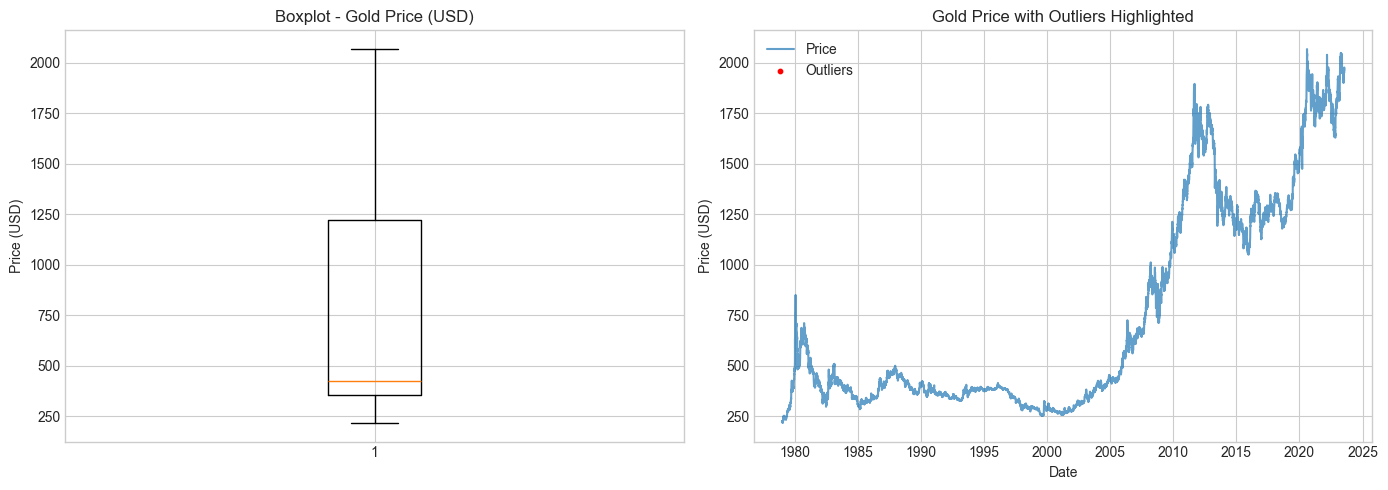

In [30]:
# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
axes[0].boxplot(df_gold['Price'].values)
axes[0].set_title('Boxplot - Gold Price (USD)')
axes[0].set_ylabel('Price (USD)')

# Time series with outliers highlighted
axes[1].plot(df_gold['Date'], df_gold['Price'], label='Price', alpha=0.7)
axes[1].scatter(outliers['Date'], outliers['Price'], color='red', label='Outliers', s=10)
axes[1].set_title('Gold Price with Outliers Highlighted')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price (USD)')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/outliers_analysis.png', dpi=150)
plt.show()

In [31]:
# IMPORTANT: For gold prices, "outliers" are actually valid high prices during bull markets
# We should NOT remove them as they represent real market conditions
# This is a key insight for financial time series

print("Decision: Keep all data points.")
print("Reason: In financial time series, extreme values are valid market conditions,")
print("not measurement errors. Removing them would bias our model.")

Decision: Keep all data points.
Reason: In financial time series, extreme values are valid market conditions,
not measurement errors. Removing them would bias our model.


## 2.6 Feature Engineering for Time Series

Creating features that capture temporal patterns and financial indicators.

In [32]:
# Make a copy for feature engineering
df_features = df_gold.copy()

# 1. Temporal Features
df_features['Year'] = df_features['Date'].dt.year
df_features['Month'] = df_features['Date'].dt.month
df_features['Day'] = df_features['Date'].dt.day
df_features['DayOfWeek'] = df_features['Date'].dt.dayofweek
df_features['Quarter'] = df_features['Date'].dt.quarter
df_features['WeekOfYear'] = df_features['Date'].dt.isocalendar().week.astype(int)

print("Temporal features created!")
df_features.head()

Temporal features created!


,Date,Price,Year,Month,Day,DayOfWeek,Quarter,WeekOfYear
0,1978-12-29,226.0,1978,12,29,4,4,52
1,1979-01-01,226.0,1979,1,1,0,1,1
2,1979-01-02,226.8,1979,1,2,1,1,1
3,1979-01-03,218.6,1979,1,3,2,1,1
4,1979-01-04,223.2,1979,1,4,3,1,1


In [33]:
# 2. Lag Features (previous days' prices)
for lag in [1, 2, 3, 5, 7, 14, 21, 30]:
    df_features[f'Price_Lag_{lag}'] = df_features['Price'].shift(lag)

print("Lag features created!")
print(f"Columns: {[col for col in df_features.columns if 'Lag' in col]}")

Lag features created!
Columns: ['Price_Lag_1', 'Price_Lag_2', 'Price_Lag_3', 'Price_Lag_5', 'Price_Lag_7', 'Price_Lag_14', 'Price_Lag_21', 'Price_Lag_30']


In [34]:
# 3. Moving Averages (trend indicators)
for window in [7, 14, 30, 60, 90]:
    df_features[f'MA_{window}'] = df_features['Price'].rolling(window=window).mean()

print("Moving average features created!")
print(f"Columns: {[col for col in df_features.columns if 'MA_' in col]}")

Moving average features created!
Columns: ['MA_7', 'MA_14', 'MA_30', 'MA_60', 'MA_90']


In [35]:
# 4. Price Returns (percentage change)
df_features['Return_1d'] = df_features['Price'].pct_change(1) * 100
df_features['Return_5d'] = df_features['Price'].pct_change(5) * 100
df_features['Return_30d'] = df_features['Price'].pct_change(30) * 100

print("Return features created!")

Return features created!


In [36]:
# 5. Volatility (rolling standard deviation)
df_features['Volatility_7d'] = df_features['Return_1d'].rolling(window=7).std()
df_features['Volatility_30d'] = df_features['Return_1d'].rolling(window=30).std()

print("Volatility features created!")

Volatility features created!


In [37]:
# 6. Price momentum indicators
df_features['Price_vs_MA7'] = (df_features['Price'] / df_features['MA_7'] - 1) * 100
df_features['Price_vs_MA30'] = (df_features['Price'] / df_features['MA_30'] - 1) * 100

# 7. Rolling min/max (support/resistance levels)
df_features['Rolling_Min_30'] = df_features['Price'].rolling(window=30).min()
df_features['Rolling_Max_30'] = df_features['Price'].rolling(window=30).max()

print("Momentum and support/resistance features created!")

Momentum and support/resistance features created!


In [38]:
# Check all features
print(f"Total features: {len(df_features.columns)}")
print(f"\nAll columns:")
print(df_features.columns.tolist())

Total features: 30

All columns:
['Date', 'Price', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'WeekOfYear', 'Price_Lag_1', 'Price_Lag_2', 'Price_Lag_3', 'Price_Lag_5', 'Price_Lag_7', 'Price_Lag_14', 'Price_Lag_21', 'Price_Lag_30', 'MA_7', 'MA_14', 'MA_30', 'MA_60', 'MA_90', 'Return_1d', 'Return_5d', 'Return_30d', 'Volatility_7d', 'Volatility_30d', 'Price_vs_MA7', 'Price_vs_MA30', 'Rolling_Min_30', 'Rolling_Max_30']


In [39]:
# Check missing values created by feature engineering
print("Missing values after feature engineering:")
missing = df_features.isnull().sum()
print(missing[missing > 0])

Missing values after feature engineering:
Price_Lag_1        1
Price_Lag_2        2
Price_Lag_3        3
Price_Lag_5        5
Price_Lag_7        7
Price_Lag_14      14
Price_Lag_21      21
Price_Lag_30      30
MA_7               6
MA_14             13
MA_30             29
MA_60             59
MA_90             89
Return_1d          1
Return_5d          5
Return_30d        30
Volatility_7d      7
Volatility_30d    30
Price_vs_MA7       6
Price_vs_MA30     29
Rolling_Min_30    29
Rolling_Max_30    29
dtype: int64


## 2.7 Handle Missing Values from Feature Engineering

In [40]:
# Drop rows with NaN (first ~90 days due to rolling windows)
df_clean = df_features.dropna().reset_index(drop=True)

print(f"Shape before cleaning: {df_features.shape}")
print(f"Shape after cleaning: {df_clean.shape}")
print(f"Rows removed: {len(df_features) - len(df_clean)}")

# Verify no missing values
print(f"\nRemaining missing values: {df_clean.isnull().sum().sum()}")

Shape before cleaning: (11626, 30)
Shape after cleaning: (11537, 30)
Rows removed: 89

Remaining missing values: 0


## 2.8 Define Target Variable

We will predict the **next day's price** (Price at t+1).

In [41]:
# Create target: next day's price
df_clean['Target'] = df_clean['Price'].shift(-1)

# Remove last row (no target available)
df_clean = df_clean.dropna().reset_index(drop=True)

print(f"Final dataset shape: {df_clean.shape}")
print(f"\nTarget variable: Price at t+1")
print(f"Target range: {df_clean['Target'].min():.2f} - {df_clean['Target'].max():.2f}")

Final dataset shape: (11536, 31)

Target variable: Price at t+1
Target range: 248.00 - 2067.20


## 2.9 Train-Test Split (Time Series)

**Important:** For time series, we must respect temporal order. No random shuffling!

In [42]:
# Define split ratio (80% train, 20% test)
train_size = 0.8
split_idx = int(len(df_clean) * train_size)

# Split data
train_data = df_clean.iloc[:split_idx].copy()
test_data = df_clean.iloc[split_idx:].copy()

print(f"Training set: {len(train_data)} samples ({len(train_data)/len(df_clean)*100:.1f}%)")
print(f"Test set: {len(test_data)} samples ({len(test_data)/len(df_clean)*100:.1f}%)")
print(f"\nTraining period: {train_data['Date'].min()} to {train_data['Date'].max()}")
print(f"Test period: {test_data['Date'].min()} to {test_data['Date'].max()}")

Training set: 9228 samples (80.0%)
Test set: 2308 samples (20.0%)

Training period: 1979-05-03 00:00:00 to 2014-09-15 00:00:00
Test period: 2014-09-16 00:00:00 to 2023-07-20 00:00:00


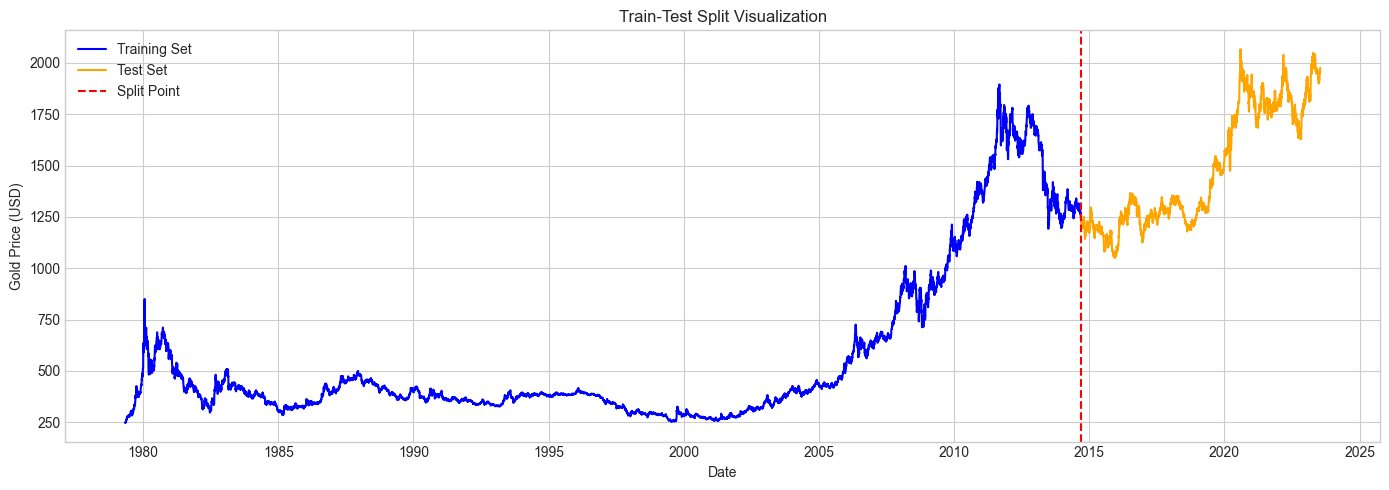

In [43]:
# Visualize train-test split
plt.figure(figsize=(14, 5))
plt.plot(train_data['Date'], train_data['Price'], label='Training Set', color='blue')
plt.plot(test_data['Date'], test_data['Price'], label='Test Set', color='orange')
plt.axvline(x=train_data['Date'].iloc[-1], color='red', linestyle='--', label='Split Point')
plt.title('Train-Test Split Visualization')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('../reports/figures/train_test_split.png', dpi=150)
plt.show()

## 2.10 Feature Scaling

In [44]:
# Define feature columns (exclude Date and Target)
feature_cols = [col for col in df_clean.columns if col not in ['Date', 'Target']]

print(f"Number of features: {len(feature_cols)}")
print(f"\nFeatures: {feature_cols}")

Number of features: 29

Features: ['Price', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'WeekOfYear', 'Price_Lag_1', 'Price_Lag_2', 'Price_Lag_3', 'Price_Lag_5', 'Price_Lag_7', 'Price_Lag_14', 'Price_Lag_21', 'Price_Lag_30', 'MA_7', 'MA_14', 'MA_30', 'MA_60', 'MA_90', 'Return_1d', 'Return_5d', 'Return_30d', 'Volatility_7d', 'Volatility_30d', 'Price_vs_MA7', 'Price_vs_MA30', 'Rolling_Min_30', 'Rolling_Max_30']


In [45]:
# Prepare X and y
X_train = train_data[feature_cols].values
y_train = train_data['Target'].values

X_test = test_data[feature_cols].values
y_test = test_data['Target'].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (9228, 29)
y_train shape: (9228,)
X_test shape: (2308, 29)
y_test shape: (2308,)


In [46]:
# Scale features using StandardScaler
# IMPORTANT: Fit only on training data to avoid data leakage!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"\nTraining set - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"Test set - Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")

Features scaled using StandardScaler

Training set - Mean: 0.000000, Std: 1.000000
Test set - Mean: 1.374350, Std: 1.424526


## 2.11 Save Processed Data

In [47]:
# Save processed datasets
train_data.to_csv('../data/processed/train_data.csv', index=False)
test_data.to_csv('../data/processed/test_data.csv', index=False)

# Save full processed dataset
df_clean.to_csv('../data/processed/gold_features.csv', index=False)

# Save scaled arrays for modeling
np.save('../data/processed/X_train_scaled.npy', X_train_scaled)
np.save('../data/processed/X_test_scaled.npy', X_test_scaled)
np.save('../data/processed/y_train.npy', y_train)
np.save('../data/processed/y_test.npy', y_test)

# Save feature names
pd.Series(feature_cols).to_csv('../data/processed/feature_names.csv', index=False)

# Save scaler for later use
import joblib
joblib.dump(scaler, '../data/processed/scaler.pkl')

print("All processed data saved successfully!")
print("\nFiles created:")
print("- ../data/processed/train_data.csv")
print("- ../data/processed/test_data.csv")
print("- ../data/processed/gold_features.csv")
print("- ../data/processed/X_train_scaled.npy")
print("- ../data/processed/X_test_scaled.npy")
print("- ../data/processed/y_train.npy")
print("- ../data/processed/y_test.npy")
print("- ../data/processed/feature_names.csv")
print("- ../data/processed/scaler.pkl")

All processed data saved successfully!

Files created:
- ../data/processed/train_data.csv
- ../data/processed/test_data.csv
- ../data/processed/gold_features.csv
- ../data/processed/X_train_scaled.npy
- ../data/processed/X_test_scaled.npy
- ../data/processed/y_train.npy
- ../data/processed/y_test.npy
- ../data/processed/feature_names.csv
- ../data/processed/scaler.pkl


## 2.12 Summary

### Preprocessing Steps Completed:

1. **Data Loading:** Loaded daily gold price dataset
2. **Missing Values:** Handled using forward-fill method
3. **Outlier Analysis:** Identified but kept (valid market data)
4. **Feature Engineering:**
   - Temporal features (Year, Month, Day, DayOfWeek, Quarter)
   - Lag features (1, 2, 3, 5, 7, 14, 21, 30 days)
   - Moving averages (7, 14, 30, 60, 90 days)
   - Returns (1d, 5d, 30d)
   - Volatility (7d, 30d)
   - Momentum indicators
5. **Target Variable:** Next day's price (t+1)
6. **Train-Test Split:** 80/20 chronological split
7. **Feature Scaling:** StandardScaler (fit on train only)

### Ready for Modeling!

In [48]:
# Final summary
print("="*50)
print("PREPROCESSING SUMMARY")
print("="*50)
print(f"Original samples: {len(df)}")
print(f"Final samples: {len(df_clean)}")
print(f"Number of features: {len(feature_cols)}")
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"\nTarget: Gold Price at t+1 (USD)")
print("="*50)

PREPROCESSING SUMMARY
Original samples: 11626
Final samples: 11536
Number of features: 29
Training samples: 9228
Test samples: 2308

Target: Gold Price at t+1 (USD)
